# Predicting Bike-Sharing Data using a Neural Network    

In this project, we will build a neural network from scratch and use it to predict daily bike rental ridership. 

Building a neural network from the ground up helps to have a much better understanding of gradient descent, backpropagation, and other concepts that are important to know before moving to higher-level tools such as PyTorch. 

The data comes from the [UCI Machine Learning Database](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights, so we will perform data scaling below, as well as some other pre-processing steps.

In [2]:
data_path = 'data/hour.csv'
rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. It can be seen in the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) It can be seen that the data is quite complicated. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. We'll be trying to capture all this with our model.

Text(0, 0.5, 'Count of total rental bikes')

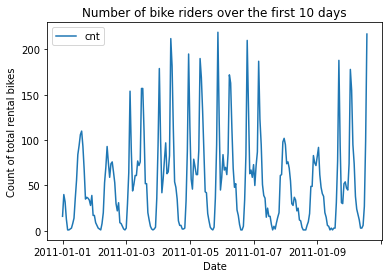

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')
plt.title("Number of bike riders over the first 10 days")
plt.xlabel("Date")
plt.ylabel("Count of total rental bikes")

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Building the network

Now it's time to build our network. The basic structure is shown below. We'll implement both the forward pass and backwards pass through the network. There are also several hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="img/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

Our neural network has been implemented in a separate module called `neural_network`. Let's load it from there, and define our loss function, which calculates the Mean Squared Error.

In [9]:
from neural_network import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here we'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but we're not overfitting to the data. If we train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

We'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, we grab a random sample of the data instead of using the whole data set. We use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently.

### Number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations we use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if we use too many iterations.  The idea is to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Conversely, the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge. Normally a good choice to start at is 0.1.

### Number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes we have, the more accurate the predictions of the model will be. However, the more hidden nodes we have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  Conversely, if the number of hidden units is too low, then the model won't have enough space to learn. The trick is to find the right balance in number of hidden units we choose. The best number of hidden nodes to use generally ends up being between the number of input and output nodes.

After testing and tuning the model, we found the hyperparameter values below to give a relatively good performance.

In [11]:
iterations = 2000
learning_rate = 1
hidden_nodes = 10
output_nodes = 1

In [12]:
## Create and train our Neural Network

import sys

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Print out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    print("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5], end="")
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.069 ... Validation loss: 0.148

Now let's plot the training and validation losses.

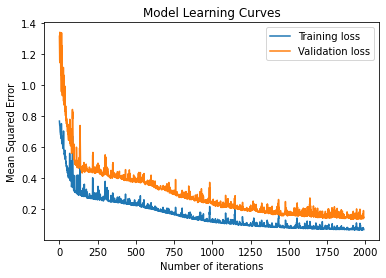

In [13]:
plt.plot(losses['train'][10:], label='Training loss')
plt.plot(losses['validation'][10:], label='Validation loss')
plt.legend()
plt.title("Model Learning Curves")
plt.xlabel("Number of iterations")
plt.ylabel("Mean Squared Error");

We can see that both training loss and validation loss follow a similar pattern, steadily decreasing during training, but at the end of the iterations this decrease slows down, especially for the validation loss. This is a sign of overfitting, so it's better to stop training at this point.

## Checking the predictions

Here, we use the test data to view how well our network is modeling the data.

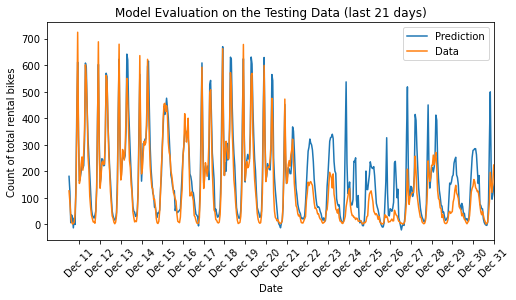

In [14]:
# Test and plot the performance of our model on the testing data

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean

ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.set_ylabel("Count of total rental bikes")

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
ax.set_xticklabels(dates[12::24], rotation=45)
ax.set_xlabel("Date")

ax.set_title("Model Evaluation on the Testing Data (last 21 days)")
ax.legend();

Here, we can see that the model performs quite well for the first half, but fails to perform after 21st December because of the Christmas Holidays in which bicycle usage dropped due to the festive. Our Network failed to capture this pattern during the Christmas festival because this dataset only has two years of data. We need to keep in mind that the Neural Networks need a lot of data to train on so that they can make accurate predictions.

## Final Comments
 
In this project, we were able to create a Neural Network from scratch, and use it for predicting a time series. We also implemented several preparation steps which are commonly used on Neural Networks, and discussed about several points to take into account at the time of deciding the model's hyperparameters.   

It's worth noting that the time series prediction task is quite difficult, especially when the data contains complex patterns, or the amount of data is limited, as happens in our case.  One improvement could be trying to implement a more complex type of Neural Network, such as a RNN (Recursive Neural Network), which contains memory cells, making it more suitable for time series prediction.